# Importing Libraries

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from sklearn.metrics import confusion_matrix , classification_report

import itertools

from collections import Counter
from keras.utils.np_utils import to_categorical

# Import Data

In [35]:
import pandas as pd
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [36]:
y = data['label']
X = data.drop(columns = ['label'] , axis = 1)

In [37]:
counter = Counter(y)
print(counter)

Counter({4: 6705, 6: 1113, 2: 1099, 1: 514, 0: 327, 5: 142, 3: 115})


# Exploratory Data Analysis (EDA)

In [38]:
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
tabular_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [39]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

# Frequency Distribution of Classes

Text(0.5, 1.0, 'Frequency Distribution of Classes')

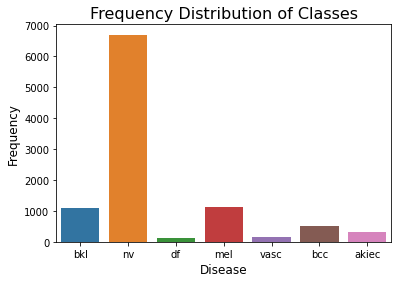

In [40]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

# Distribution of Disease over Gender

Text(0.5, 1.0, 'Gender of Patient')

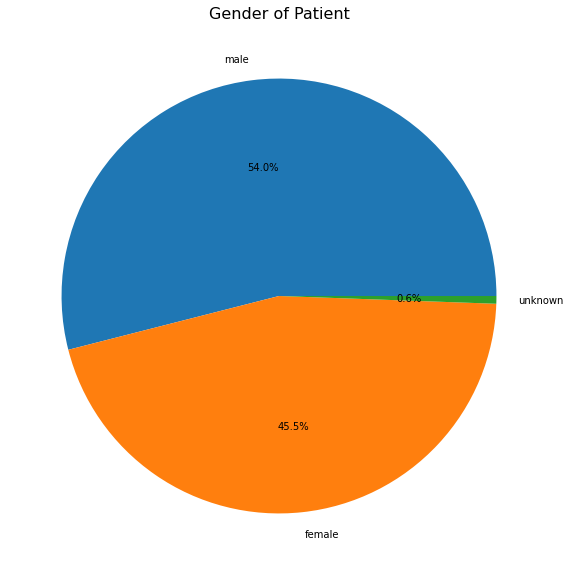

In [41]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

# Histogram of Age of Patients

Text(0.5, 1.0, 'Histogram of Age of Patients')

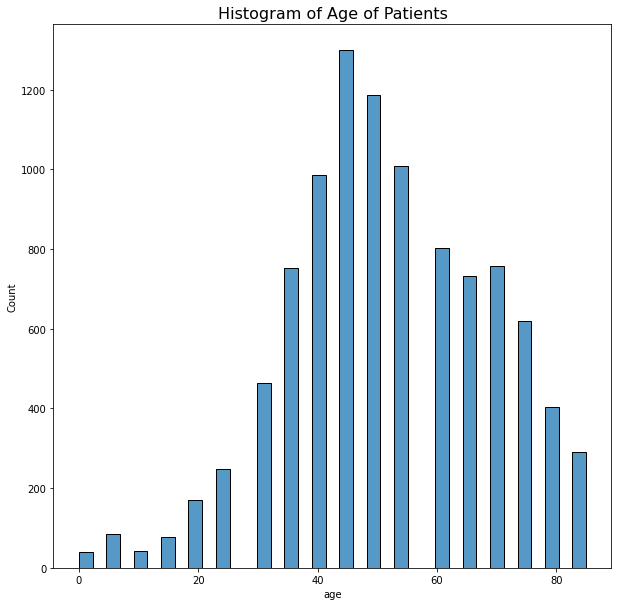

In [42]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)

# Location of disease over Gender

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

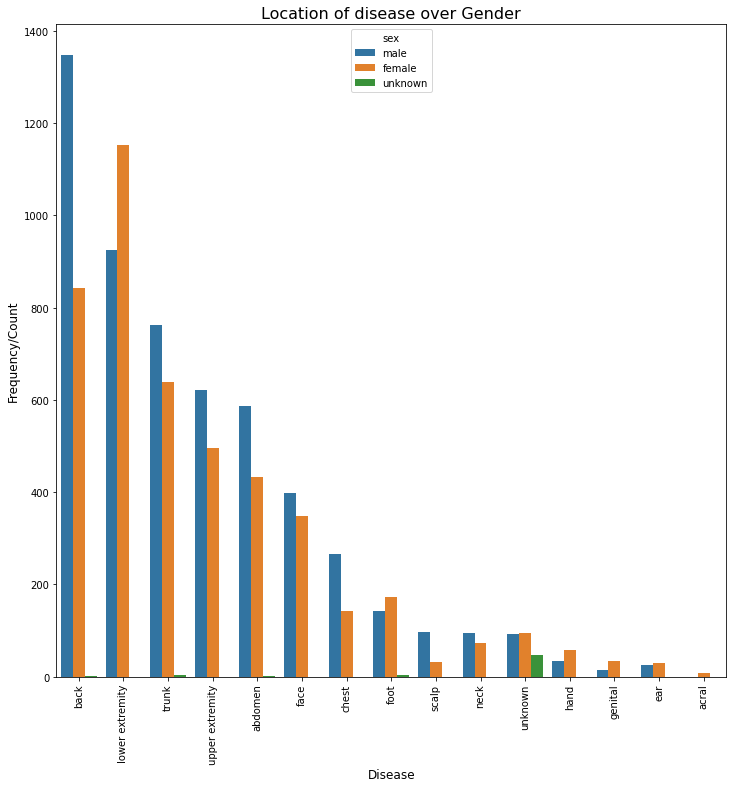

In [43]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

**Smote**

In [44]:
oversample = SMOTE()
X,y  = oversample.fit_resample(X,y)

In [45]:
counter = Counter(y)
print(counter)

Counter({2: 6705, 4: 6705, 3: 6705, 6: 6705, 5: 6705, 1: 6705, 0: 6705})


In [46]:
X.shape

(46935, 2352)

In [47]:
X = np.array(X).reshape(-1,28,28,3)
print('Shape of X :',X.shape)

Shape of X : (46935, 28, 28, 3)


In [48]:
def getcode(n) : 
    for x , y in classes.items() : 
        if n == x : 
            return y

In [49]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X),16))) : 
    plt.subplot(4,4,n+1)
    #image = cv2.imread(X[i])
    plt.imshow(X[i])   
    plt.axis('off')
    plt.title(getcode(y[i]))


In [50]:
print('Shape of y' , y.shape)
print("First Value of y" , y[0])

Shape of y (46935,)
First Value of y 2


In [51]:
y=to_categorical(y)

In [52]:
print('Shape of y' , y.shape)
print("First Value of y" , y[0])

Shape of y (46935, 7)
First Value of y [0. 0. 1. 0. 0. 0. 0.]


# Standardization and Splitting Data

In [53]:
# Stander Scaler
# X = (X-np.mean(X))/np.std(X)

# Spliting data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

# Model Training

In [54]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [55]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [56]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback , es])

Train on 30038 samples, validate on 7510 samples
Epoch 1/20
29568/30038 [============================>.] - ETA: 0s - loss: 1.6360 - accuracy: 0.4241

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: saving model to best_model.h5
30038/30038 [==============================] - 2s 74us/sample - loss: 1.6282 - accuracy: 0.4263 - val_loss: 1.1824 - val_accuracy: 0.5349
Epoch 2/20
29824/30038 [============================>.] - ETA: 0s - loss: 0.9432 - accuracy: 0.6511
Epoch 00002: saving model to best_model.h5
30038/30038 [==============================] - 2s 69us/sample - loss: 0.9415 - accuracy: 0.6520 - val_loss: 0.7817 - val_accuracy: 0.7126
Epoch 3/20
29568/30038 [============================>.] - ETA: 0s - loss: 0.6835 - accuracy: 0.7490
Epoch 00003: saving model to best_model.h5
30038/30038 [==============================] - 2s 56us/sample - loss: 0.6823 - accuracy: 0.7497 - val_loss: 0.5937 - val_accuracy: 0.7822
Epoch 4/20
29824/30038 [============================>.] - ETA: 0s - loss: 0.5375 - accuracy: 0.8065
Epoch 00004: saving model to best_model.h5
30038/30038 [==============================] - 2s 51us/sample - loss: 0.5368 - accuracy: 0.8066 - val_loss: 0.468

# Plot Accuracy and Loss

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
test_score = model.evaluate(x= X_test, y= y_test)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

Test Loss:  0.31364011610308
Test Accuracy:  0.9223394


In [60]:
model.load_weights('best_model.h5')


In [61]:
classes_labels=[]
for key in classes.keys():
    classes_labels.append(key)
print(classes_labels)


[4, 6, 2, 1, 5, 0, 3]


In [62]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)
#y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)
print(y_true[:5])
print(y_pred[:5])


[5 1 4 0 5]
[5 1 4 0 5]


In [63]:
cm=confusion_matrix(y_true,y_pred,labels=classes_labels)
print(cm)


[[1075  114  109   41    5   25    5]
 [ 158 1128   51   10    0   17    1]
 [  38   25 1149   13    0   33    4]
 [   3    1    9 1277    0   21    7]
 [   7    0    1   12 1338    0    0]
 [   0    0    8    9    0 1342    0]
 [   0    0    0    0    0    2 1349]]


In [64]:
    def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
        plt.figure(figsize= (10, 10))
        plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation= 45)
        plt.yticks(tick_marks, classes)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
            print('Normalized Confusion Matrix')
        else:
            print('Confusion Matrix, Without Normalization')
        print(cm)
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

In [65]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)


In [66]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= range(7), title = 'Confusion Matrix')

Confusion Matrix, Without Normalization
[[1342    9    8    0    0    0    0]
 [  21 1277    9    7    3    0    1]
 [  33   13 1149    4   38    0   25]
 [   2    0    0 1349    0    0    0]
 [  25   41  109    5 1075    5  114]
 [   0   12    1    0    7 1338    0]
 [  17   10   51    1  158    0 1128]]


In [67]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1359
           1       0.94      0.97      0.95      1318
           2       0.87      0.91      0.89      1262
           3       0.99      1.00      0.99      1351
           4       0.84      0.78      0.81      1374
           5       1.00      0.99      0.99      1358
           6       0.89      0.83      0.86      1365

    accuracy                           0.92      9387
   macro avg       0.92      0.92      0.92      9387
weighted avg       0.92      0.92      0.92      9387



# Model Testing

In [68]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)

In [69]:

from keras.models import load_model
best_model=load_model('./best_model.h5')

In [70]:
from keras.applications.imagenet_utils import preprocess_input
import copy
from keras import backend as K

def superimpose(img, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return img, heatmap, superimposed_img

In [71]:
def _plot(best_model, cam_func, img, cls_true):
    """plot original image, heatmap from cam and superimpose image"""
    
    # for cam
    x = img.reshape(1,28,28,3)
#     x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-1].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))
    true =cls_true

    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.suptitle('True label: '  + str(getcode(true)) + ' / Predicted label : ' + str(getcode(cls_pred)))
    plt.tight_layout()
    plt.show()

In [72]:
## Grad-CAM function

def grad_cam(model, x, layer_name):
    """Grad-CAM function"""
    
    cls = np.argmax(model.predict(x))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :]
    
    weights = np.mean(grads_val) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0

    return cls, cam

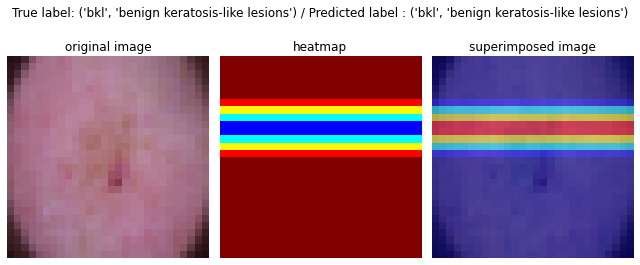

In [73]:
_plot(best_model=best_model, cam_func=grad_cam, img=X_test[70], cls_true=y_true[70])